# EIT-CEM Quick-Start

In [2]:
#Fixing paths
import sys
import time
sys.path.append('../../FEIT_codes') # Add the parent directory to the path list

#Importing modules
from FEIT_onefile import *
import seaborn as sns
sns.set_context("talk")


#Experiment name
exp_name="exp2"

In [3]:
"Basic Definitions"
r=1            #Circle radius
L=16           #Number of Electrodes
per_cober=0.5  #Percentage of area covered by electrodes
rotate=0       #Rotation

#Return object with angular position of each electrode
ele_pos=electrodes_position(L, per_cober, rotate)

#### Malhas

In [4]:
refine_n=8 #Refinement mesh
n_in=8     #Vertex on elec.
n_out=2    #Vertex on gaps (Sometimes it is important.)

mesh_inverse=MyMesh(r, refine_n, n_in, n_out, ele_pos)
mesh_forward=MyMesh(r, refine_n*3, n_in*3, n_out*3, ele_pos)


Numero de elementos:  594
Numero de elementos:  3700


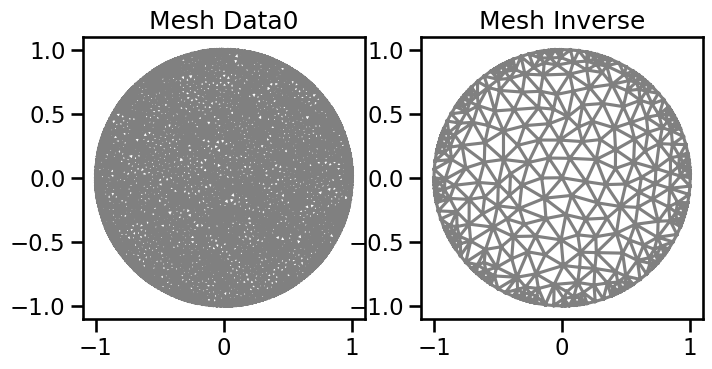

In [5]:
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plot(mesh_forward, title="Mesh Data0");
plt.subplot(1,2,2)
plot(mesh_inverse, title="Mesh Inverse");
print("Numero de elementos: ", mesh_inverse.num_cells())
print("Numero de elementos: ", mesh_forward.num_cells())

### Forward Problem

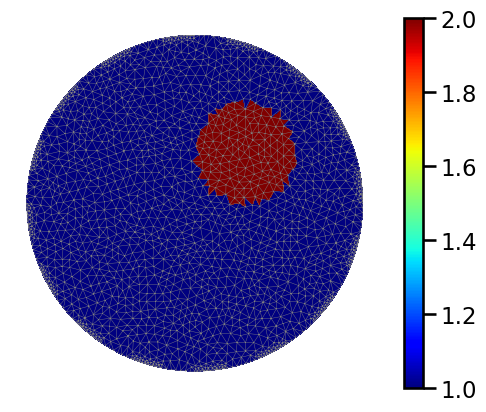

In [6]:
"Solution Forward problem"
Q = FunctionSpace(mesh_forward, "DG", 0) #Define Function space with basis Descontinuous Galerkin
ValuesCells0=GammaCircle(mesh_forward,2,1.0,0.3, 0.3, 0.3); #mesh, cond_in, cond_out, radius, certerx, cerntery
gamma = Function(Q)
gamma.vector()[:]=ValuesCells0

"Plot"
plot_figure(gamma, name="", map="jet");
plot(mesh_forward, linewidth=0.3)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.savefig("figures/{}/gamma_plus.png".format(exp_name), bbox_inches='tight', transparent=True)

In [7]:
"Forward Problem"
#Definições básicas
z=np.ones(L)*2.5E-5     #Impedance of each electrode
l=L-1                                           #Numero of experiments
I_all=current_method( L , l, method=2)           #Current
print(I_all)
print(z)

[[ 1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. 

In [8]:
#Solver
ForwardObject=ForwardProblem(mesh_forward, z)

VD=FiniteElement('CG',mesh_forward.ufl_cell(),1) #Solution Space Continous Galerkin
list_ur, list_U = ForwardObject.solve_forward(VD, I_all, gamma)
list_U0 = (np.array(list_U).flatten())
print(list_U0[0:L])

[ 0.59683392 -0.58225101 -0.1770248  -0.09720831 -0.06548889 -0.04681257
 -0.03301847 -0.02162958 -0.01117799 -0.00067388  0.01052077  0.02352289
  0.04025457  0.06430932  0.10463569  0.19520837]


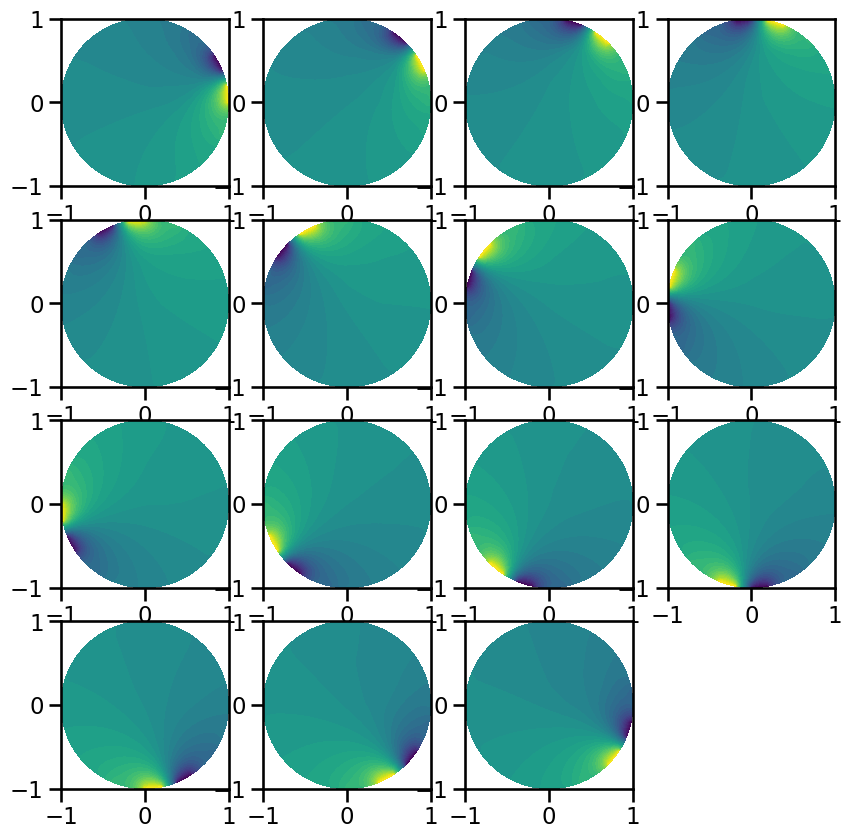

In [9]:
plt.figure(figsize=(10, 10))
for i in range(0, l):
    plt.subplot(4,4,i+1)
    plot(list_ur[i])
plt.show()

### Solver parameters

In [10]:
solverconfig_dict= { 
            #General Parameters
            "step_limit": 30,
            #"tau": 1.05,
            "weight_value": False,
            "innerstep_limit": 1,
            #General newton method parameters
            "mu_i":0.85,
            "mu_max":0.999,
            "nu":0.97,
            "R":0.97,
            "noise_type":'uniform'
}

In [11]:
#LM = Levenberg-Marquadt
noise_range = [0.5, 1, 1.5, 2]
noise_range=noise_range
list_exps = ["NTK"+"_"+str(noise) for noise in noise_range]
experiments = {}
for exp in list_exps: 
    experiments[exp] = {} 
    experiments[exp]["config"] = solverconfig_dict.copy()
    experiments[exp]["results"] = {}

#Setting parameters for each experiment
for noise in noise_range:
    exp="NTK"+"_"+str(noise)
    experiments[exp]["config"]["noise_level"]=noise/100
    experiments[exp]["config"]["inner_method"]="Tikhonov"
    experiments[exp]["config"]["innerstep_limit"]=100
    experiments[exp]["config"]["Tik_c0"]=0.01
    experiments[exp]["config"]["Tik_q"]=1

In [12]:

for key, experiment in experiments.items():
    print(key)

    noise_level=experiment["config"]["noise_level"]
    noise_type=experiment["config"]["noise_type"]
    list_U0_noised=fn_addnoise(list_U0, noise_level, noise_type, seed=42)
    InverseObject=InverseProblem(mesh_inverse, list_U0_noised, I_all, z)
    #First guess
    guess_r=np.ones(mesh_inverse.num_cells())
    InverseObject.set_firstguess(guess_r)
    InverseObject.tau=0
    
    #"Solver Parameters"
    InverseObject.set_solverconfig(**experiment["config"])
    #Solution
    InverseObject.set_answer(gamma, mesh_forward)


    #Call Solver
    start_time = time.time()
    InverseObject.solve_inverse()
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Tempo de execução: {elapsed_time} segundos")
    #Getting results
    experiment["results"]["res_vec"]=np.copy(InverseObject.res_vec)
    experiment["results"]["error_vec"]=np.copy(InverseObject.error_vec)
    experiment["results"]["gamma_k"]=InverseObject.gamma_all
    experiment["results"]["innerstep_vec"]=InverseObject.innerstep_vec
    experiment["results"]["time"]=elapsed_time
    experiment["results"]["noise_level"]=noise_level


NTK_0.5
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Error (%)= 26.540399150834666 Residue (%)= 9.920277691374075  step: 0 Inner step:  0
mu_n 0.85
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Error (%)= 25.440757861913184 Residue (%)= 3.2362363688444917  step: 1 Inner step:  1
mu_n 0.85
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Error (%)= 24.51771649014447 Residue (%)= 2.308214517446066  step: 2 Inner step:  1
mu_n 0.84915
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Error (%)= 23.867315747507643 Residue (%)= 1.8354698379420344  step: 3 Inner step:  1
mu_n 0.84830085
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Error (%)= 23.39694586346057 Residue (%)= 1.5314536351665837  step: 4 Inner step:  1
mu_n 0.84745254915
*** Warning: Degree of exact solution may be ina

In [13]:
import pickle
save_it=True
if save_it:
        for key, experiment in experiments.items():
                with open('data/{}/{}.data'.format(exp_name, key), 'wb') as config_dictionary_file:
                        pickle.dump(experiment, config_dictionary_file)